# Demo
We create a hierarchical-naviagable-small-world index and key-value backend, insert 900 images into it, and then query them with text using CLIP embeddings for semantic similarity.

### Environment Setup

In [ ]:
import sys
!{sys.executable} -m pip install transformers pillow torch lmdb pydantic pillow

In [2]:
import os
import logging
import time
from importlib import reload
module_path = os.path.abspath(os.path.join('/workspaces/vector_db/jfdb'))
if module_path not in sys.path:
    sys.path.append(module_path)

from jfdb import hsnw
from jfdb.utils import helpers
from jfdb.nodes.node import Node

# Instantiate Database
In this PoC, the `database` is just an HSNW index on top of a memory-mapped file backend. We could easily fit all the images in memory, but where's the fun in that

In [ ]:
# initialize db object
reload(logging)
logging.basicConfig(
    format='%(name)s:%(levelname)s:%(funcName)s: %(message)s',
    level=logging.INFO
)

db = hsnw.DataBase(
    L=4,  # num hierarchical layers
    M=10,  # number of edges to make during node insertion
    d=512,  # expected node embedding dimensions
    M_max=20,  # max edges to allow before pruning
    M_max0=40,  # max edges to allow before pruning (dense layer only)
    ef_construction=10,  # controls search breadth
)

In [5]:
db.backend.drop_backend()
db.backend.init_backend()

root:WARNING:drop_backend: Emptied database index
root:INFO:init_backend: Initialized default_db


In [ ]:
# insert media from folder
folder_path = '/workspaces/vector_db/images'
timed_inserts = []

# Iterate over files in the folder
for i, filename in enumerate(os.listdir(folder_path)):
  if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
    file_path = os.path.join(folder_path, filename)
    image = Image.open(file_path)
    image_embeddings = helpers.get_embedding_from_image(image, db.processor, db.model)
    node = Node(
        id=filename.split('.')[0],
        layers=db.L,
        embedding=image_embeddings[0],
        filepath=filename
    )
    t0 = time.time()
    db.insert(node)
    timed_inserts.append((i, time.time()-t0))

# Database stats

In [18]:
print(f'Inserted {len(os.listdir(folder_path))} images')
backend_mb = db.backend.env.info()['map_size'] / 1e6
print(f'We initialized our index backend to {backend_mb}mb')
print(f'Index backend storage is {round(db.backend.get_percent_full()*100, 3)}% full')

Inserted 898 images
We initialized our index backend to 10.0mb
Index backend storage is 37.11% full


# Semantic Search
Queried <10% of nodes in order to serve approximate best result!

root:INFO:search_embedding: Traversed 81 during search


pikachu 22.178775787353516


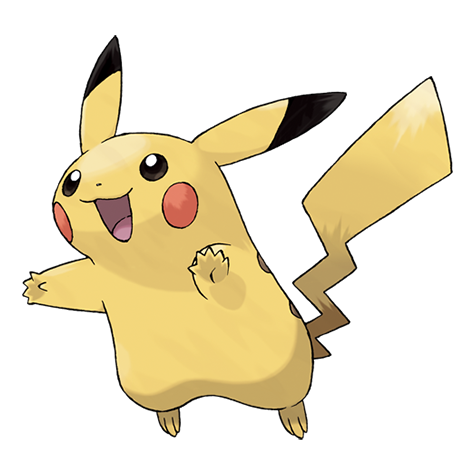

In [9]:
search_text = 'a yellow mouse with black-tipped ears and red cheeks'
n, sim = db.search(search_text)
file_path = os.path.join(folder_path, n.filepath)
image = Image.open(file_path)
print(n, sim)
image